In [3]:
!pip install m3_learning --no-deps
!pip install -r requirements.txt

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import time
from torch.optim.lr_scheduler import StepLR

from m3_learning.util.rand_util import rand_tensor
from m3_learning.viz.style import set_style
from m3_learning.nn.random import random_seed
set_style("printing")
random_seed(seed=42)

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [5]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

In [6]:
class Linear_func:
    def __init__(self, x, slope=[0,1], b=[0,1], size=(1,1),batch_size=1000):
        self.x = x
        self.slope = slope
        self.b = b
        self.size = size
        self.batch_size = batch_size

    def compute(self, params, device='cuda'):
        out = torch.zeros(
            (params.shape[0], self.x.shape[0],
             self.size[0], self.size[1])
        )

        params = params.to(device)
        _slope = params[:, 0, 0, 0]
        _b = params[:, 0, 1, 0]
        x = (
            torch.cat(params.shape[0] * [self.x])
            .reshape(params.shape[0], -1)
            .to(device)
            )
        x = torch.transpose(x, 0, 1).to(device)

        _out = _slope * x + _b
        out[:, :, 0, 0] = torch.transpose(_out, 0, 1)

        return (torch.sum(out, dim=3), out)
    
    def sampler(self, device='cuda'):
        slope = rand_tensor(
            min=self.slope[0],
            max=self.slope[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )

        b = rand_tensor(
            min=self.b[0],
            max=self.b[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )

        _params = torch.torch.stack((slope, b))
        _params = torch.atleast_2d(_params)
        _params = torch.transpose(_params, 0, 1)
        _params = torch.transpose(_params, 1, 2)
        
        return (self.compute(_params, device=device), _params)

In [7]:
class Multiscale1DFitter(nn.Module):

    def __init__(self, function, x_data, input_channels, num_params, scaler=None,
                 post_processing=None, device='cuda', loops_scaler=None, **kwargs):
        self.input_channels = input_channels
        self.scaler = scaler
        self.function = function
        self.x_data = x_data
        self.post_processing = post_processing
        self.device = device
        self.num_params = num_params
        self.loops_scaler = loops_scaler

        super().__init__()

        # Input block of 1d convolution
        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        # Fully connected block
        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        # 2nd block of 1d-conv layers
        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),
        )

        # Flatten layer
        self.flatten_layer = nn.Flatten()

        # Final embedding block
        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 16),
            nn.SELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, self.num_params),
        )

    def forward(self, x, n=-1):
        x = torch.swapaxes(x, 1, 2)  # Swap axes 1 and 2
        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (n, 256))
        xfc = self.hidden_xfc(xfc)

        x = torch.reshape(x, (n, 2, 128))
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)

        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)
        unscaled_param = embedding

        if self.scaler is not None:
            unscaled_param = (embedding * torch.tensor(self.scaler.var_ ** 0.5).to(self.device)
                              + torch.tensor(self.scaler.mean_).to(self.device))
        else:
            unscaled_param = embedding

        fits = self.function(unscaled_param, self.x_data, device=self.device)
        out = fits

        if self.post_processing is not None:
            out = self.post_processing.compute(fits)
        else:
            out = fits

        if self.loops_scaler is not None:
            out_scaled = (out - torch.tensor(self.loops_scaler.mean).to(self.device)) / torch.tensor(self.loops_scaler.std).to(self.device)
        else:
            out_scaled = out

        return out_scaled, unscaled_param

In [8]:
def linear_function(params, x, device='cuda:6'):
    params = params.to(device)
    x = x.to(device)
    slope = params[:, 0].type(torch.float).unsqueeze(1).to(device)
    intercept = params[:, 1].type(torch.float).unsqueeze(1).to(device)
    y = slope * x + intercept
    return y

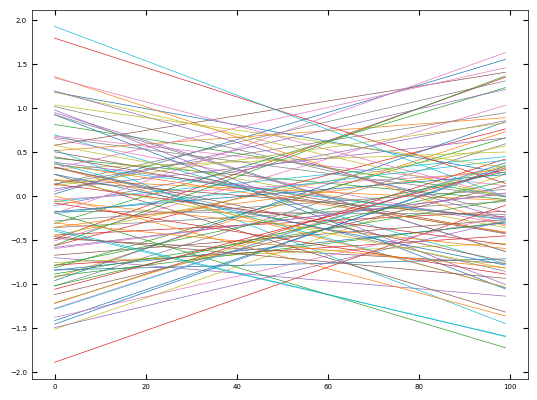

In [9]:
x_values = torch.linspace(-1, 1, 100)
constructor = Linear_func(x=x_values, slope=[-1,1], b=[-1,1], batch_size=100000)
output = constructor.sampler()
spectra, params = output
spectra_full, spectras = spectra

dataloader = DataLoader(spectra_full, batch_size=5000, shuffle=True, num_workers=0)

for i in range(100):
    plt.plot(spectra_full[i, :, 0], "-")

In [10]:
model = Multiscale1DFitter(function=linear_function, x_data=x_values, input_channels=1, num_params=2, device=device).to(device)

In [11]:
random_seed(seed=42)
loss_func = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-5)
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [12]:
epochs = 100
for epoch in range(epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 0
    model.train()

    for train_batch in dataloader:
        train_batch = train_batch.to(device)
        pred, _ = model(train_batch)
        loss = loss_func(train_batch.squeeze(2), pred)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item() * pred.shape[0]
        total_num += pred.shape[0]
    train_loss /= total_num
    scheduler.step()

    print("epoch : {}/{}, loss = {:.8f}".format(epoch, epochs, train_loss))
    print("--- %s seconds ---" % (time.time() - start_time))

epoch : 0/100, loss = 0.44022397
--- 3.595089912414551 seconds ---
epoch : 1/100, loss = 0.40750143
--- 1.32493257522583 seconds ---
epoch : 2/100, loss = 0.37381386
--- 1.3189842700958252 seconds ---
epoch : 3/100, loss = 0.33124997
--- 1.3142457008361816 seconds ---
epoch : 4/100, loss = 0.28136322
--- 1.9238700866699219 seconds ---
epoch : 5/100, loss = 0.22812801
--- 1.592580795288086 seconds ---
epoch : 6/100, loss = 0.18703708
--- 1.493826150894165 seconds ---
epoch : 7/100, loss = 0.15687074
--- 1.4066452980041504 seconds ---
epoch : 8/100, loss = 0.13512530
--- 1.3809778690338135 seconds ---
epoch : 9/100, loss = 0.12062642
--- 2.0237417221069336 seconds ---
epoch : 10/100, loss = 0.11126038
--- 1.6069505214691162 seconds ---
epoch : 11/100, loss = 0.10433442
--- 1.545017957687378 seconds ---
epoch : 12/100, loss = 0.09819048
--- 1.6768896579742432 seconds ---
epoch : 13/100, loss = 0.09221788
--- 1.4171738624572754 seconds ---
epoch : 14/100, loss = 0.08623904
--- 2.0738632678

In [ ]:
model.eval
spectra_generated, params = model(train_batch)
rand = np.random.randint(0, 100)
plt.plot(spectra_generated[rand, :].detach().cpu().numpy(), "r")
plt.plot(train_batch[rand, :].detach().cpu().numpy(), "b")